In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d400.csv')

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

C:\Users\kamoh\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [2]:
import numpy as np
import datetime as dt
from datetime import datetime, timedelta

# Reading the input data
dfr=pd.read_csv('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

#data types: Date column is of object type. It shall be converted to datetime type. Date_Value is int64 
# which needs to be converted to float to be able to indicate tenth of degrees.
dfr['Date'] =  pd.to_datetime(dfr['Date'])
dfr['Data_Value']=0.1*pd.to_numeric(dfr['Data_Value']) #conversion is done at the same time
#exclude leap days as suggested by the teacher
dfr = dfr[dfr['Date'] !='2008-02-29']
dfr = dfr[dfr['Date'] !='2012-02-29']
dfr.set_index('Date', inplace=True)
dfr.sort_index(inplace=True)

# Variable number of data per station! It means that number of data for calculating the mean value of TMIN or TMAX
# in each day for all stations is varying.
# Using groupby first on Date we classify all data for a single day. Then we can use Element as the second item 
# of groupby to classify only TMIN or only TMAX in a single day (of course for all stations). This will end up in
# a long list which is boring and also time consuming and in fact not needed! What we need here is only the mean
# value, which can directly added to the groupby command using agg function. Arbitrarily we can add count, which 
# shows how many TMIN or TMAX has been used for the calculation of mean in a single day.
dfr = dfr.groupby([dfr.index,'Element']).agg(['mean','count'])
dfr.columns = dfr.columns.droplevel(0) #drop one level
#pivot for tmin?
dfr = dfr.unstack()
#dfr=dfr['mean']
dfr = dfr.drop('count', 1)
dfr.columns = dfr.columns.droplevel(0) #drop one level
#From this point we need to take 2 different slices from dfr to continue: dfr1 for 2005-2014 and dfr2 for 2015
#Remove any data before or after the period: 2005-2014 and take the rest as dfr1:
dfr1=dfr.loc['2005-01-01': '2014-12-31'] 
#Take data for 2015 for the overlay graph as dfr2:
dfr2=dfr.loc['2015-01-01': '2015-12-31'] 
dfr1.index = dfr1.index.strftime('%m-%d')
dfr2.index = dfr2.index.strftime('%m-%d')
dff1 = dfr1.groupby(dfr1.index).agg('max')
dff2 = dfr2.groupby(dfr2.index).agg('max')
dff1['TTmax1'] = dff1['TMAX']
dff2['TTmax2'] = dff2['TMAX']
dff1['TTmin1'] = dfr1.groupby(dfr1.index).agg('min')['TMIN']
dff2['TTmin2'] = dfr2.groupby(dfr2.index).agg('min')['TMIN']
dff1 = dff1[['TTmin1','TTmax1']]
dff2 = dff2[['TTmin2','TTmax2']]
# criteria for overlay graph:
low2015 = dff2[dff2['TTmin2'] < dff1['TTmin1']]
low2015 = low2015.drop('TTmax2',1)
high2015 = dff2[dff2['TTmax2'] > dff1['TTmax1']]
high2015 = high2015.drop('TTmin2',1)
dff = pd.merge(dff1,low2015, how='left',left_index = True, right_index=True)
dff = pd.merge(dff,high2015, how='left',left_index = True, right_index=True)

# Generate a list of dates from 01.01.2015 to 01.01.2015 through 1 day (year will be deleted in the nex step. 
# Because we need a date type object for the sake of visualization on the horizontal axis on a monthly basis)
x = np.arange(0,365,1)
dummydates = []
#establishin the starting date as dates[0] inside dates list
dummydates.append(datetime.strptime('2015-01-01', '%Y-%m-%d'))
for d in x[1:]:
    d =d.astype('float64') #Maybe a bug: timedate doesn't function with int32!
    dummydates.append(dummydates[0] + timedelta(days = d))
dff.index = pd.Series(dummydates)

<IPython.core.display.Javascript object>


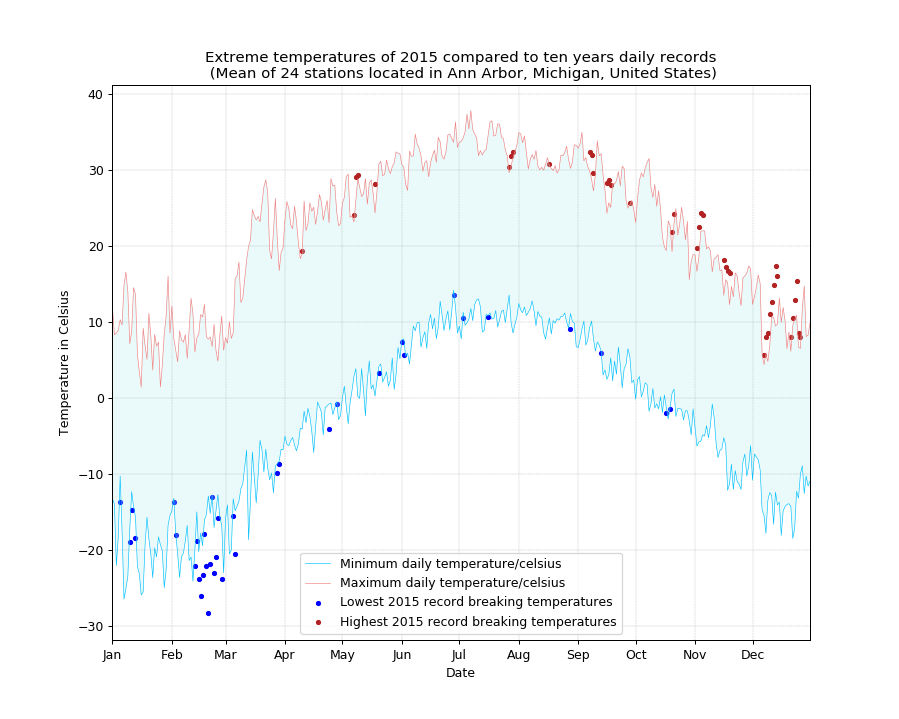

In [3]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.get_backend()
from datetime import datetime
from matplotlib.dates import DateFormatter, MonthLocator
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k')

ax.plot_date(dff.index, dff1['TTmin1'],'deepskyblue', linewidth=0.5, markersize=1)
ax.plot_date(dff.index, dff1['TTmax1'],'lightcoral', linewidth=0.5, markersize=1)

ax.scatter(dff.index, dff['TTmin2'],color='blue', s=10)
ax.scatter(dff.index, dff['TTmax2'],color='firebrick', s=10)

#To only show the months in x axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b")) 

#To delete the default whitespace in the graph extents (default=0.05)
plt.margins(x=0)
plt.xlabel('Date')
plt.ylabel('Temperature in Celsius')
plt.title('Extreme temperatures of 2015 compared to ten years daily records\n (Mean of 24 stations located in Ann Arbor, Michigan, United States)')

# positioning the legend to lower center using bbox_to_anchor
plt.legend(['Minimum daily temperature/celsius', 'Maximum daily temperature/celsius','Lowest 2015 record breaking temperatures', 'Highest 2015 record breaking temperatures','Daily temperature variation'],
           bbox_to_anchor=(0.5, 0),
           loc='lower center')
plt.grid(color='gray', linestyle='-.', linewidth=0.2)
# fill the area between the linear data and exponential data
dates = list(dff.index)
plt.gca().fill_between(dates, 
                       dff['TTmin1'], dff['TTmax1'], 
                       facecolor='paleturquoise', 
                       alpha=0.25)